## Imports

In [1]:
import torch
import torch.utils.data as data_utils
import pandas as pd
import numpy as np
from torchsummary import summary
import os
from torch import nn
import matplotlib.pyplot as plt
import torch.optim as optim
import scipy.ndimage

torch.cuda.empty_cache()


from nn_class_definitions import *
NET = conv_v1
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = NET().to(device)
summary(net,(723,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 704]              84
              ReLU-2               [-1, 4, 704]               0
         MaxPool1d-3               [-1, 4, 140]               0
            Conv1d-4               [-1, 8, 121]             648
              ReLU-5               [-1, 8, 121]               0
         MaxPool1d-6                [-1, 8, 24]               0
           Flatten-7                  [-1, 192]               0
            Linear-8                  [-1, 384]          74,112
              ReLU-9                  [-1, 384]               0
           Linear-10                  [-1, 192]          73,920
             ReLU-11                  [-1, 192]               0
           Linear-12                    [-1, 5]             965
Total params: 149,729
Trainable params: 149,729
Non-trainable params: 0
-------------------------------

## Data

### Defs

In [2]:
def from_laser_scan_to_image(laser_scan, max_range = 15):
    imgsize = 16
    laser_increment = 0.0087 #rad
    ang_start = -3.14159
    angle = ang_start - laser_increment
    image = np.zeros((imgsize*2,imgsize*2))
    for _range in (laser_scan):
        angle += laser_increment
        x = int((np.cos(angle + np.pi/2)*_range)/max_range*imgsize)
        y = int((np.sin(angle + np.pi/2)*_range)/max_range*imgsize)
        if int(np.math.sqrt(x*x + y*y))+1>= int(max_range):
            continue
        i = imgsize*2-(y+imgsize)
        j = x+imgsize
        image[i,j ]+=1
    image[imgsize,imgsize] = 0
    return (image>0)*1.0

    
def laser_tensor_to_image_tensor(laser_tensor, max_range = 15):
    if laser_tensor.shape.__len__() == 1:
        laser_tensor = torch.reshape(laser_tensor, [1,laser_tensor.shape[0]])
    laser_numpy = laser_tensor.cpu().numpy()
    images = []
    for i in range(laser_numpy.shape[0]):
        print("\r",end="")
        print(i,end="")
        images.append(from_laser_scan_to_image(laser_numpy[i,:],max_range))
    images = np.array(images)
    images_tensor = torch.tensor(images).float().to(device)
    return images_tensor
    

In [3]:
def read_and_clean_dataset_csv(PATH_TO_DATAFRAME, image_net = False, max_range = 15):
    complete_dataframe = pd.read_csv(PATH_TO_DATAFRAME) # read dataset
    if image_net:
        complete_dataframe.replace([np.inf],0,inplace=True) # substitute infinites of dataset
    else:
        complete_dataframe.replace([np.inf],max_range,inplace=True)
        
    complete_dataframe = complete_dataframe.iloc[1:,1:]
    
    train_dataframe  = complete_dataframe.iloc[:,1:]
    target_dataframe = complete_dataframe.iloc[:,0]
    
    train_tensor  = torch.tensor(train_dataframe.values.astype(np.float32)).to(device)
    target_tensor = torch.tensor(target_dataframe.values.astype(np.int64)) .to(device)

    if image_net:
        train_tensor = laser_tensor_to_image_tensor(train_tensor, max_range)
    
    n_train = int(train_tensor.shape[0]*0.9)
    n_test = train_tensor.shape[0] - n_train
    
    complete_dataset = data_utils.TensorDataset(train_tensor, target_tensor)
    train_dataset, test_dataset = data_utils.random_split(complete_dataset, [n_train, n_test])
    return train_dataset, test_dataset

class LaserScanDataset(data_utils.Dataset):
    def __init__(self, path_to_dataset, is_image, max_range = 15):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.folder = path_to_dataset
        self.dir_elements = os.listdir(path_to_dataset)
        self.len = self.dir_elements.__len__()
        self.is_image = is_image
        for idx in range(self.len):
            print("\r",end="")
            print(idx,end="")
            img_path = os.path.join(self.folder, "{}.pt".format(idx))
            x, y = torch.load(img_path)
            y = y.long()
            x = x.cpu().detach().numpy()
            x = np.where(x > max_range, max_range, x)
            x = scipy.ndimage.median_filter(x,size=5)
            x = torch.Tensor(x)
            if idx == 0:
                s = x.shape
                self.data = torch.zeros((self.len,s[0])).float()
                s = y.shape
                self.labels = torch.zeros((self.len)).long()

            self.data[idx,...] = x
            self.labels[idx,...] = y

        if is_image:
            self.data = laser_tensor_to_image_tensor(self.data,max_range=max_range)


    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.data[idx,...], self.labels[idx,...]
        #return (x.to(self.device),y.to(self.device))

    def show(self, idx):
        x, y = self.data[idx,...], self.labels[idx,...]
        data = x.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        print("\n{}".format(y))
        fig, axs = plt.subplots(1)
        if self.is_image:
            plt.imshow(data)
        else:
            axs.plot(data)
        plt.show()




### Load

In [4]:
# DEFINE INPUT VARIABLE
PATH_TO_DATASET = "/home/lorenzo/Datasets/environment_classification/trial_with_segments"
MAX_RANGE = 15
with torch.no_grad():
    dataset = LaserScanDataset(PATH_TO_DATASET,net.is_2d(), 15)
classes = ("t", "intersection", "curve", "rect", "block")

89726


4


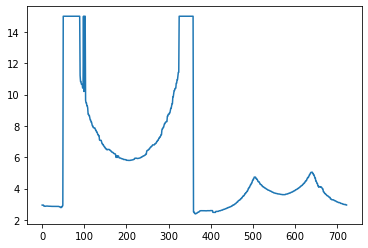

In [5]:
for i in range(dataset.__len__()):
    x, y = dataset.__getitem__(i)
    if y == 4:
        dataset.show(i)
        break
        
        


## Train

### Definitions

In [6]:
def basic_train(network, data_loader, criterion, optimizer, n_epochs, is_images = True):
    loss_history = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("\r",end="")
        print("epoch {} of {}".format(epoch,n_epochs),end="")
        dataloader_iterator = enumerate(data_loader, 0)
        n_batchs = len(list(dataloader_iterator))
        dataloader_iterator = enumerate(data_loader, 0)
        for i, data in dataloader_iterator:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
    


    plt.plot(loss_history)
    plt.show()
    return loss_history

def test_net(net, test_loader):
    for i, data in enumerate(test_loader, 0):
        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)     
        loss = criterion(outputs, labels)
        output = outputs.float().detach().cpu().numpy()
        labels_ = np.argmax(output,axis=1)
        labels = labels.int().cpu().numpy()
        correct = np.sum(labels_ == labels)
        accuracy = correct/output.shape[0]
        print("Loss: {:.3f}, Accuracy: {:.3f}".format(loss.item(), accuracy))
        return accuracy

### Run Training

lr: 0.001
epoch 123 of 124

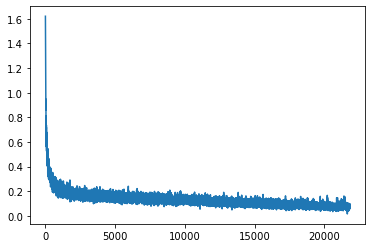

Loss: 0.052, Accuracy: 0.977


In [7]:
LR = [0.001]#, 0.00009, 0.00005]
BATCH_SIZE = 128*4
N_EPOCHS = 124

train_dataloader = data_utils.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = data_utils.DataLoader(dataset, batch_size = dataset.__len__(), shuffle=True)
criterion = nn.CrossEntropyLoss()
losses_list = []
#net = NET()
#net = net.to(device).float()
for lr in LR:
    torch.cuda.empty_cache()
    print("lr: {}".format(lr))
    optimizer = optim.Adam(net.parameters(),lr=lr,)
    loss_hist = basic_train(net,train_dataloader, criterion, optimizer, N_EPOCHS)
    accuracy = test_net(net, train_dataloader)
    
l_min = (30,0,0,0)
for l in losses_list:
    if l[0] < l_min[0]:
        l_min = l


In [8]:
test_dataloader = data_utils.DataLoader(dataset, batch_size = BATCH_SIZE*10, shuffle=True)
accuracy = test_net(net, test_dataloader)
print(accuracy)

Loss: 0.059, Accuracy: 0.976
0.9763671875


In [9]:
from datetime import datetime

now = datetime.now()
NN_PATH = "/home/lorenzo/catkin_ws/src/lorenzo/laser_scan_nn/trained_nets/{}__acc{}".format(NET.__name__,accuracy)
print(NN_PATH)
torch.save(net.state_dict(), NN_PATH)

/home/lorenzo/catkin_ws/src/lorenzo/laser_scan_nn/trained_nets/conv_v1__acc0.9763671875


# TEST NET

In [10]:
test_net = NET()
test_net.load_state_dict(torch.load("/home/lorenzo/catkin_ws/src/lorenzo/laser_scan_nn/trained_nets/conv_v2_acc1.0"))
test_net.eval()
test_net = test_net.to(device)
labels = ("t", "intersection", "curve", "rect", "block")
test_net = net

RuntimeError: Error(s) in loading state_dict for conv_v1:
	Unexpected key(s) in state_dict: "linear_relu_stack.13.weight", "linear_relu_stack.13.bias". 
	size mismatch for linear_relu_stack.0.weight: copying a param with shape torch.Size([16, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([4, 1, 20]).
	size mismatch for linear_relu_stack.0.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([4]).
	size mismatch for linear_relu_stack.3.weight: copying a param with shape torch.Size([32, 16, 5, 5]) from checkpoint, the shape in current model is torch.Size([8, 4, 20]).
	size mismatch for linear_relu_stack.3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for linear_relu_stack.7.weight: copying a param with shape torch.Size([512, 512]) from checkpoint, the shape in current model is torch.Size([384, 192]).
	size mismatch for linear_relu_stack.7.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for linear_relu_stack.9.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([192, 384]).
	size mismatch for linear_relu_stack.9.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for linear_relu_stack.11.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([5, 192]).
	size mismatch for linear_relu_stack.11.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([5]).

In [ ]:
n=0
print(dataset.__len__())
for i in range(dataset.__len__()):
    x, y = dataset.__getitem__(i)
    s = x.shape
    x = torch.reshape(x, [1,s[0],s[1]])
    test_net
    if y == 4:
        dataset.show(i)
        label = test_net(x.to(device))
        print(label)


8115


IndexError: tuple index out of range